# Project 10 - Sparse Logistic Regression
*By: Derek Sweet, Johanna Weiss, Emanuele Zangrando, Sercan Albut*

Deliverables:
1. Analyze in depth the approaches described in the papers 1.pdf 2.pdf 3.pdf and the theory related to them.
2. Consider the sparse logistic problem described in  1.pdf and perform experiments on three of the dataset using the methods SNS, PD, GSS
3. Analyze the results following the lines given in the paper 1.pdf


Introduction:

*   Sparsity constraints are leveraged to solve many problems such as regression feature selection, compressed sensing techniques and portfolio optimization.
*   This project addresses and recreates three algorithms that produce sparse solutions by enforcing sparsity with a $L^{0}$ norm constraint
*   As suggested, we focused on experiments using Logistic Regression

##### Imports and Utilities

In [ ]:
###########
# IMPORTS #
###########

!pip install datapackage
import os
import json
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
import datapackage
import pandas as pd
import itertools
import scipy
from copy import deepcopy
from timeit import default_timer as timer
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter
from sklearn.preprocessing import MinMaxScaler
import matplotlib.ticker as ticker

np.random.seed(0)

from IPython.display import Math, HTML

In [ ]:
#########
# UTILS #
#########

def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def findsubsets(s, n):
  subsets = list(itertools.combinations(s, n))
  return subsets

def generate_init_W(x, s):
  n_col = x.shape[1]
  
  init_W = [np.zeros(n_col)]

  for i in range(10):
    init_ws = [np.zeros(shape=n_col)]
    num_ones = np.random.choice(range(1,s)) 
    ones = np.ones(num_ones)
    zeros = np.zeros(n_col-num_ones)
    init_w = np.concatenate((ones, zeros), axis=0)
    np.random.shuffle(init_w)

    init_W.append(init_w*np.random.normal(size=n_col))
  
  return init_W

In [ ]:
####################
# Global Variables #
####################

test_size = 0.9
random_state = 42

## Models and Methods


---










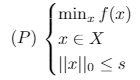

### Sparse Neighborhood Search (SNS)



*   SNS addresses the problem by suitably splitting the search in a search for a better set of active variables and for a better point in that particular subset.
*   The main idea is to introduce a new variable $y$ that will take care of the ”combinatorial side” of problem

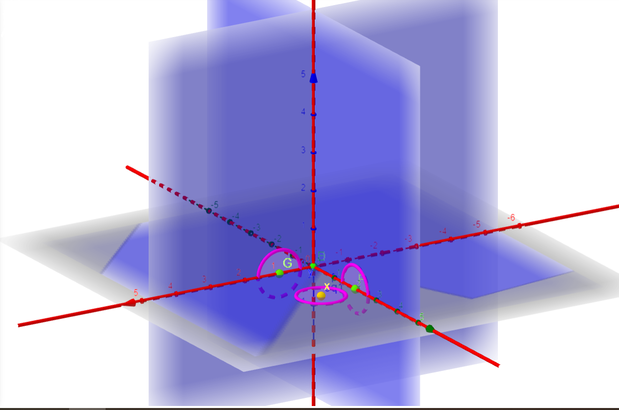


In [ ]:
class SNS(object):
  """
  Class for performing Sparse Neighborhood Search on a logistic regression
  
  Methods:
  sns(self,xi, rho, theta, eta, mu, delta, gamma, s)
  _pgls(self, w, gamma, delta, y = None)

  """

  def __init__(self, X, y):
    """
    Parameters:
    X: Data input features
    y: Dependent variable
    """

    self.X_train = (X-np.mean(X,axis=0))/np.std(X,axis=0)
    self.y_train = 2*y-1

    np.random.seed(0)

  def _projection(self, w, y):
    """
    Method for projecting the y

    Parameters:
    w: parameter weights
    y: subspace of the ball based on a (0,1) vector 

    Output:
    projection of w, y
    """

    num_col=len(y)
    return w* (np.ones(num_col)-y)

  
  def _loss(self, w, flag = "train"):
    """
    Loss function method for SNS

    Parameters:
    w: parameter weight
    flag: dafaults to "train" and exists if loss needs to be calculated on the test data 

    Output:
    loss: negative log likelihood of logistic regression
    """
    if flag == "train":
      z = self.X_train
      t = self.y_train

    loss = np.sum(np.log(1+np.exp(-t*(z.dot(w)))))

    return loss

  def _d_loss(self, w, flag = "train"):
    """
    First order derivative of loss function for SNS

    Parameters:
    w: parameter weight
    flag: dafaults to "train" and exists if loss needs to be calculated on the test data 

    Output:
    grad: derivative of negative log likelihood of logistic regression with respect to w
    """

    if flag == "train":
      z = self.X_train
      t = self.y_train

    grad = -z.T@( t*  sigmoid(-t* (z@w) ) ) 
    
    return np.array(grad)


  def _pgls(self, w, gamma, delta, y = None):
    """
    Projected-Gradient Line Search method

    Parameters:
    w: parameter weights
    gamma: armijo parameter gamma for line search (0,.5)
    delta: armijo parameter delta for line search (0,1)
    y: if 'None' then y of all ones length of w is generated. Otherwise it takes y array length of w.

    Output:
    w2: returns new weights based on pgls armijo line search
    """
    
    num_col = len(w)
    alpha = 1

    if y is None:
      y = np.ones(num_col)
    w1 = self._projection(w-self._d_loss(w),y)
    d = w1 - w

    while self._loss(w + alpha*d) > (self._loss(w) + (gamma * alpha * self._d_loss(w).T.dot(d))):
      alpha = delta*alpha

    w2 = w + alpha * d

    return w2
  

  def _generate_ys(self, y_fixed,s):
    """
    Method to generate all feasible ys

    Parameters:
    y_fixed: initial y vector subspace
    s: the size of the ball globally

    Output:
    ys: list of all feasible ys
    """
    idx = list(range(len(y_fixed)))
    comb = []
    for num in range(s):
      comb.extend(findsubsets(idx, s-num))

    ys = [np.ones(len(y_fixed))]
    for mask in comb:
      y = np.ones(len(y_fixed))
      for i in mask:
        y[i] = 0
      ys.append(np.array(y))
    return np.array(ys)


  def _generate_ball_ys(self, y_fixed, ys, w, rho, xi, gamma, delta):
    """
    Method to generate the feasible y neighbors

    Parameters:
    y_fixed: the fixed y
    ys: list of all feasible ys
    w: parameter weights
    rho: maximum number of switches you can have in y
    xi: padding term
    gamma: gamma for line search (0,.5)
    delta: delta for line search (0,1)

    Output:
    z2: returns list of feasible (w,y)
    """

    ball_ys = np.array([y for y in ys if np.linalg.norm(y-y_fixed,ord=1) <= rho])
    
    if len(ball_ys) == 0:
      ball_ys = y_fixed.reshape(1,len(y_fixed))

    reverse_ys = np.subtract(np.ones(len(y_fixed)),ball_ys)
    constrained_w = reverse_ys * w
    combined_w_ys = zip(constrained_w,ball_ys)

    z2 = np.array([(a,b) for a,b in combined_w_ys if self._loss(a) <= self._loss(self._pgls(a, gamma, delta))+xi])

    return z2


  def sns(self,xi, rho, theta, eta, mu, delta, gamma, s, init_w):
    """
    Main Sparse Neighborhood Search algorithm

    Parameters:
    xi: padding term
    rho: maximum number of switches you can have in y
    theta: updating parameter for eta
    eta: tolerance parameter
    delta: delta for line search (0,1)
    gamma: gamma for line search (0,.5)
    s: the size of the ball globally
    init_w: initial weight parameter

    Output:
    final_loss: final loss of optimal w
    w_k: list of optimal weights
    t: time to run in seconds
    loss_history: history of all the losses
    """

    # Start timer
    start = timer()

    # Set training data
    n_row_train, n_col = self.X_train.shape
    t = self.y_train
    z = self.X_train

    # Initialize w of zeros
    w_0 = init_w

    # Create initial y
    np.random.seed(0)
    num_s = np.random.choice(range(self.X_train.shape[1]-s,self.X_train.shape[1]-1))
    one = np.ones(num_s)
    zero = np.zeros(len(w_0)-num_s)
    y_0 = np.concatenate((one, zero), axis=0)
    np.random.shuffle(y_0)
    y = deepcopy(y_0)

    # Generate all feasible ys
    ys = self._generate_ys(y,s)

    # Initialize variables for k loop stopping condition
    error = 100
    tol = 1e-4

    # Copy of W_0 and y to prevent side effects
    w_k = deepcopy(w_0)
    y_k = deepcopy(y)

    # Initalize loss history and time history
    loss_history = [self._loss(w_k)]
    time_history = [0]

    iteration = 0
    # Begin looping k with stopping condition if tol (1e-4) is greater than error
    while error>tol:
      iteration +=1
      # print(iteration, timer() - start, error)
        
      # Generate new w
      w_k_ = self._pgls(w_k, gamma, delta , y_k)

      # Given new w generate ball
      W_k = self._generate_ball_ys(y_k, ys, w_k_, rho, xi, gamma, delta)

      # If W_k does not have any feasible points in the discrete ball 
      if len(W_k)==0:
        
        # If loss of weights of new w are less than previous w-eta then update w to new w
        temp_loss = self._loss(w_k_)
        if temp_loss < self._loss(w_k) - eta:

          # Append new loss to loss history
          loss_history.append(temp_loss)
          time_history.append(timer() - start)
          w_k = w_k_

        # If loss of weights of new w are greater than previous w+eta then calculate new error update w to new w and calculate new eta
        else:
          error = np.linalg.norm(w_k-w_k_)
          w_k = w_k_
          eta = theta*eta
        
        # Update mu
        mu=delta*mu

      # If W_k has at least 1 feasible point(s) in the discrete ball 
      else:

        ind = 0
        flag = True

        # Looping points of w_k in the ball index is less than the length of w and flag is True
        while ind < len(W_k) and flag == True:
          w_j , y_j = W_k[ind]
          # Initialize variables for loop j 
          j  = 0

          # Loop j
          while True:

            # Generate new w
            w_j = self._pgls(w_j, gamma, delta , y_j)
            

            # If loss of new w is less than loss in k loop - eta then
            temp_loss = self._loss(w_j)
            # print(temp_loss, self._loss(w_k_)-eta)
            if temp_loss < self._loss(w_k_)-eta:
              
              # Append new loss to loss history
              loss_history.append(temp_loss)
              time_history.append(timer() - start)

              # Update new error 
              error = np.linalg.norm(w_k-w_j)

              # Update w_k to w_j values
              w_k ,y_k = w_j,y_j

              # Update mu and break out of both k and j loops
              mu = delta*mu
              flag = False
              break
            
            # If loss of new w is greater than loss in k loop - eta then
            else:

              # If this long projection condition is met
              if np.linalg.norm(  w_j - self._projection( w_j- self._d_loss(w_j) ,y_j) ) > mu + np.linalg.norm(  w_k - self._projection( w_k- self._d_loss( w_k),y_k) ):

                # Update j and start the j loop over again
                j += 1
                continue

              # If long condition above is not met add to index and break j loop. If ind is greater than len of w k will break as well
              else:
                ind+=1
                break
    # Calculate final loss
    final_loss = self._loss(w_k)

    # Stop timer and calculate execution time in seconds
    end = timer()
    time = end - start

    # Return final optimal w
    return (final_loss, list(w_k), time, loss_history, time_history)

 

### Penalty Decomposition (PD)

* PD addresses the problem by switching from hard constraint formulation into a penalizing one.
* The main idea is to introduce a new variable $y$ and a penalty function by adding the quadratic term $\frac{\rho}{2}||x−y||$ to the loss function.
* Instead of minimizing the loss, one minimizes this new function using a Block coordinate method.
* To get sparse results, gradually augment the penalty term and use old points as restarting points.

In [ ]:
class PD(object):
  """
  Class for performing Penalty Decomposition on a logistic regression
  
  Methods:
  pd(self,xi, rho, theta, eta, mu, delta, s)

  """

  def __init__(self, X, y):
    """
    Parameters:
    X: Data input
    y: Dependent variable
    """
    self.X_train = (X-np.mean(X,axis=0))/np.std(X,axis=0)
    self.y_train = 2*y-1
    np.random.seed(0)

  def _loss(self, w, flag = "train"):
    """
    Loss function method for SNS

    Parameters:
    w: parameter weight
    flag: dafaults to "train" and exists if loss needs to be calculated on the test data 

    Output:
    loss: negative log likelihood of logistic regression
    """
    if flag == "train":
      z = self.X_train
      t = self.y_train

    loss = np.sum(np.log(1+np.exp(-t*(z@w))))

    return loss

  def _d_loss(self, w, flag = "train"):
    """
    First order derivative of loss function for SNS

    Parameters:
    w: parameter weight
    flag: dafaults to "train" and exists if loss needs to be calculated on the test data 

    Output:
    grad: derivative of negative log likelihood of logistic regression with respect to w
    """
    if flag == "train":
      z = self.X_train
      t = self.y_train

    grad = -z.T@( t*  sigmoid(-t* (z@w) ) ) 

    return np.array(grad)

  def _qrho(self, w, y, rho):
    """
    Adding penalty term to loss

    Parameters:
    w: parameter weights
    y: vector of length the same as w 
    rho: penalty coefficient (scalar)

    Output: qrho, grad_q_rho
    
    """
    qrho = self._loss(w) + ((rho/2)*(np.linalg.norm(y-w)**2))

    grad_qrho = self._d_loss(w) + rho*(w-y)

    return qrho, grad_qrho


  def _bfgs_w(self,w,y,rho):
    """
    Method to perform search of optimal w

    Parameters:
    w: parameter weights
    y: vector of length the same as w 
    rho: penalty coefficient (scalar)

    Output: 
    opt_w: returns an updated w
    """

    def _qrho_w(w2):
      qrho_w = self._loss(w2) + ((rho/2)*(np.linalg.norm(y-w2)**2))
      return qrho_w

    opt_w = scipy.optimize.minimize(_qrho_w,w,method='L-BFGS-B')
    opt_w = opt_w.x

    return opt_w


  def _bfgs_y(self,w,y,rho,s):
    """
    Method to perform search of optimal y

    Parameters:
    w: parameter weights
    y: vector of length the same as w 
    rho: penalty coefficient (scalar)

    Output: 
    opt_y: returns an updated y
    """

    def _qrho_y(y2):
      return self._loss(w) + ((rho/2)*(np.linalg.norm(y2-w)**2))

    w_index = np.abs(w).argsort()[:len(w)-s]
    opt_y = deepcopy(w)
    opt_y[w_index]=0
    return opt_y


  def pd(self, rho, e_k, sigma, s, init_w):
    """
    Main Sparse Neighborhood Search algorithm

    Parameters:
    xi: padding term
    rho: penalty coefficient (scalar)
    theta: updating parameter for eta
    eta: tolerance parameter
    delta: delta for line search (0,1)
    s: the size
    init_w: initial weight parameter

    Output:
    final_loss: final loss of optimal w
    w_k: list of optimal weights
    time: time to run in seconds
    loss_history: history of all the losses
    time_history: history of all the cpu times
    """

    # Start timer
    start = timer()

    # Initialize variables, weights, and y for algorithm
    n_row_train, n_col = self.X_train.shape
    w = np.array(init_w)
    y = np.random.normal(size=n_col)
    rand_coordinates = np.random.choice(n_col,n_col-s,replace=False)
    y[rand_coordinates]=0  
    w_feas = np.zeros(n_col)

    # Calculate tree - parameter bigger than loss at the feasible point we know
    tree = np.max([self._loss(w_feas),self._qrho(self._bfgs_w(w,y,rho),y,rho )[0]])

    # Set initial w and y to the opt_w and opt_y
    opt_w, opt_y = w,y #y

    # Initalize loss and time history
    loss_history = [self._loss(w)]
    time_history = [0]

    # Start k loop with stopping condition when norm of opt w - y is less than 1e-4 
    while np.linalg.norm(opt_w-opt_y) > 1e-6:  #-4

      # Create copies of opt_w and opt_y for j loop
      opt_w_j,opt_y_j = deepcopy(opt_w),deepcopy(opt_y)

      # Start j loop while norm of grad_qrho is greater than e_k and j is less than 1000
      j = 0
      grad_norm = np.linalg.norm(self._qrho(opt_w_j, opt_y_j, rho)[1]) 

      stopping_1 = 1
      while  stopping_1>e_k: #grad_norm> e_k: #and j<=1000: #np.linalg.norm(self._qrho(opt_w_j, opt_y_j, rho)[1]) > e_k and j<=1000:

        opt_w_j,opt_w_j_ = self._bfgs_w(opt_w_j, opt_y_j, rho),opt_w_j
        opt_y_j,opt_y_j_ = self._bfgs_y(opt_w_j, opt_y_j, rho, s),opt_w_j

        stopping_1 = np.max(   np.array([np.max(np.abs(opt_w_j-opt_w_j))/np.max([1,np.max(np.abs(opt_w_j))]),np.max(np.abs(opt_y_j-opt_y_j))/np.max([1,np.max(np.abs(opt_y_j))])])   )

        grad_norm = np.linalg.norm(self._qrho(opt_w_j, opt_y_j, rho)[1])

        # Iterate j
        j+=1

      # Update rho
      rho = sigma*rho

      # Set opt_w and opt_y to the output from the j loop
      opt_w,opt_y = opt_w_j,opt_y_j

      # Calculate optimal opt_qrho based on output from j loop
      opt_qrho = self._qrho(self._bfgs_w(opt_w, opt_y, rho), opt_y, rho)[0]
      
      # If the opt_qrho is greater than tree then update optimal y to the feasible starting point
      if opt_qrho > tree:
        opt_y = w_feas

      # Append new loss to loss and time history
      final_loss = self._loss(opt_w)
      loss_history.append(final_loss)
      time_history.append(timer() - start)
        
    # Stop timer and calculate execution time in seconds
    end = timer()
    time = end - start

    return final_loss, list(opt_w), time, loss_history, time_history

### Greedy Sparse Simplex Method (GSS)

* Addresses the problem by using a line search approach.
* At every iteration, the GSS algorithms looks if all the ”available”coordinates are saturated: if they are not, it will look for the best value in all the coordinate lines, otherwise it will ”free” one of them and look in another one.

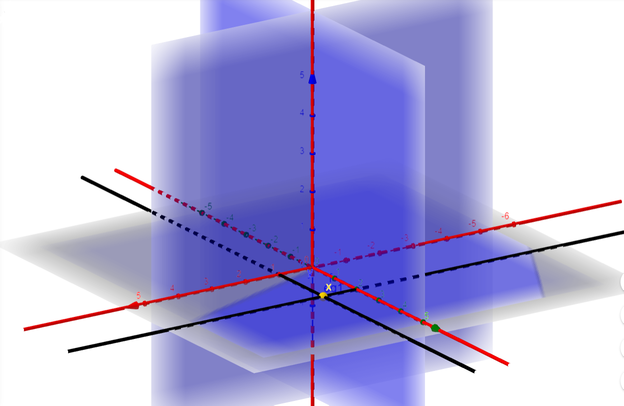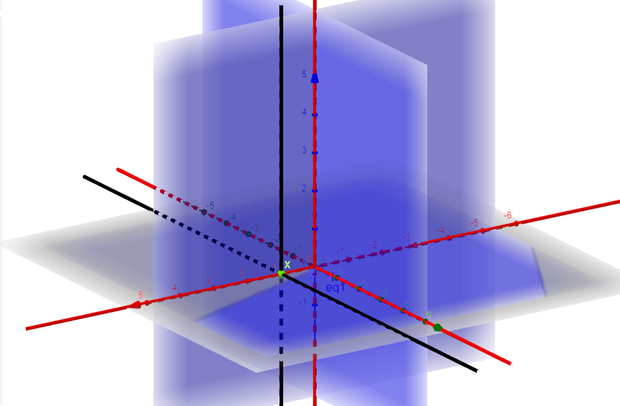

In [ ]:
class GSS(object):
  """
  Class for performing Greedy Sparse-Simplex method on a logistic regression
  
  Methods:
  gss(self, start, w)

  """

  def __init__(self, X, y):
    """
    Parameters:
    X: Data input features
    y: Dependent variable
    """
    self.X_train = (X-np.mean(X,axis=0))/np.std(X,axis=0)
    self.y_train = 2*y-1
    np.random.seed(0)

  def _gss_return(self, start, w):
    """
    Final return statement built into a method for consistent execution in main algorithm

    Parameters:
    start: start of timer
    w: parameter weights

    Output:
    final_loss: the output of the loss function
    w: parameter weights
    time: total run time in seconds
    """

    # Calculate Loss
    final_loss = self._loss(w)

    # Stop timer and calculate execution time in seconds
    end = timer()
    time = end - start

    return final_loss, w, time


  def _bfgs(self,w,idx, t0=0):
    '''
    Breadth first greedy search method

    Parameters:
    w: weights in which we want to calculate the loss
    idx: index of the line direction of the search

    Output:
    opt_t: optimal point in the line indicated by idx

    '''
    
    def loss_i(t):
     e_i = np.identity(len(w))[idx]
     return self._loss(w+t*e_i)

    opt_t=scipy.optimize.minimize(loss_i,0, method='L-BFGS-B',tol=1e-10)
    return opt_t.x[0]
 

  def _loss(self,w,flag = "train"):
    """
    Loss function method for SNS

    Parameters:
    w: parameter weights
    flag: dafaults to "train" and exists if loss needs to be calculated on the test data 

    Output:
    loss: negative log likelihood of logistic regression
    """
    if flag =='train':
      regressors = self.X_train
      response  = self.y_train
    elif flag =='test':
      regressors = self.X_test
      response = self.y.test
    loss =   np.sum(np.log(1+ np.exp(-response*(regressors@w)))) 
    return loss


  def gss(self,s, init_w, max_it=10000):
    '''
    Main Greedy Sparse-Simplex algorithm method
    
    Parameters:
    s: the size of the ball globally
    max_it = maximum iterations (default: 10000)
    init_w: initial weight parameter

    Output:
    final_loss: final loss of optimal w
    w: list of optimal weights
    time: time to run in seconds
    loss_history: history of all the losses
    time_history: history of all the cpu times

    '''

    # Start timer
    start = timer()

    # Initalize loss and time history list
    loss_history = []
    time_history = []

    # Set training data
    n_row_train, n_col = (self.X_train).shape

    # Initialize w
    w_0 = init_w
    iter_counter = 0
    w = deepcopy(w_0)

    # Calculate starting loss
    current_loss = self._loss(w)

    # Append loss to loss and time history
    loss_history.append(current_loss)
    time_history.append(0)

    iteration = 0
    # Start first loop until maximum iterations or breaking condiditons in loop
    while iter_counter<=max_it:

      # If the zero norm of w is less than s 
      if np.linalg.norm(w,ord=0)<s:

        # Initialize empty list for t and f
        t = []
        f = []

        # Loop through each column in the data
        for i in range(n_col):
          
          # Create mask for the column i
          e_i = np.identity(n_col)[i]

          # Run bfgs to get optimal t
          t_opt = self._bfgs(w,i)

          # Calculate optimal loss based on optimal t for the vector with only one column index non zero value
          f_opt = self._loss(w+t_opt*e_i)

          # Append t_opt and f_opt to t and f lists respectively
          t.append(t_opt)
          f.append(f_opt)

        # Convert t and f to numpy arrays and get the index of the best loss
        t,f = np.array(t),np.array(f)
        best_index = np.argmin(f)

        # If the best_index loss is less than the current loss then 
        if f[best_index]<current_loss:

          # set the best_index loss as the new current loss
          current_loss = f[best_index]

          # Append loss to loss and time history
          loss_history.append(current_loss)
          time_history.append(timer() - start)

          # update the w by adding the best_index t for the chosen n_col of that index
          w = w+t[best_index]*np.identity(n_col)[best_index]

        else:

          # Stop timer and calculate execution time in seconds
          end = timer()
          time = end - start

          return current_loss, list(w), time, loss_history, time_history

      # If the zero norm of w is equal to s 
      elif np.linalg.norm(w,ord=0)==s:
        
        # Create a list of non zero weights
        I_1 = [idx for idx in range(n_col) if w[idx]!=0]

        # Create a list of empty lists the size of the non zero weights vector
        t = [[] for i in I_1]
        f = [[] for i in I_1]

        # Loop through all non zero weights
        for index,i in enumerate(I_1):
          
          # Create an identity masking vector for the columns in non_zero loop
          e_i = np.identity(n_col)[i]
          
          # Begin second loop of all columns
          for j in range(n_col):
            
            # Create an identity masking vector for the column in in all columns loop
            e_j = np.identity(n_col)[j]

            # Find optimal t using bfgs by subtracting w by wi and apply masking from previous step
            t_ij = self._bfgs(w-w[i]*e_i,j)

            # Calculate optimal loss
            f_ij = self._loss(w-w[i]*e_i+t_ij*e_j)

            # Append optimal loss to 
            t[index].append(t_ij)
            f[index].append(f_ij)
        
        # Convert t and f to numpy arrays and get the position of the smallest loss
        t,f = np.array(t),np.array(f)
        i_opt,j_opt = tuple(np.argwhere(f == np.min(f))[0])

        # If the smallest loss is less than current loss then 
        if current_loss>f[i_opt,j_opt]:
          
          # Create masking to get optimal ij
          e_i_opt  = np.identity(n_col)[I_1[i_opt]]
          e_j_opt  = np.identity(n_col)[j_opt]

          # Update current loss to optimal ij
          current_loss = f[i_opt,j_opt]

          # Append loss to loss and time history
          loss_history.append(current_loss)
          time_history.append(timer() - start)

          # Update w based on optimal ij
          w = w-w[I_1[i_opt]]*e_i_opt+t[i_opt,j_opt]*e_j_opt

        else:
          # Stop timer and calculate execution time in seconds
          end = timer()
          time = end - start
      
          return current_loss, list(w), time, loss_history, time_history

## Data and Implementation


---



##### Initializations

In [ ]:
# Initialize dictinary to store results
results = {}

In [ ]:
##########################################
# INITIALIZATION FOR RUNNING EXPERIMENTS #
##########################################

# Initalize variables for running models
xi = 1e3
gamma = 0.9
theta = 0.5
eta = 1e-5
delta = 1e-6
mu = 1e-6
s1 = 3
s2 = 4
rho = 1
sigma = 1.05
e_k = 1e-4

### Heart (Statlog)

* The Heart Statlog data has 13 features of mixed-integer size containing demographic and health diagnostics of individuals. 
* Each individual is identified to if there is absence or presence of heart disease. 
* There are 270 observations in total.

In [ ]:
#############################
# LOAD HEART (STATLOG) DATA #
#############################

heart_url = 'https://datahub.io/machine-learning/heart-statlog/datapackage.json'

# to load Data Package into storage
heart_package = datapackage.Package(heart_url)

# to load only tabular data
heart_resources = heart_package.resources
for resource in heart_resources:
    if resource.tabular:
        heart = pd.read_csv(resource.descriptor['path'])

heart_X = heart[heart.columns[:-1]].to_numpy()
heart_y = np.array(heart['class']=='present').astype(int)

# heart_init_W = generate_init_W(heart_X,s1)

heart_init_W =[[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],
               [0.,0.,0.,0.,0.,0.,-1.33195167,0.,0.,0.,0.,1.9560789,0.],
               [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.31612369,0.,0.,0.03203253],
               [0.,0.,0.,0.,0.,0.,0.,0.,0.08393515,0.,0.,0.,0.],
               [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.26496068,0.,0.],
               [0.06922996,0.,0.,0.,0.48474833,0.,0.,0.,0.,0.,0.,0.,0.],
               [0.,0.,0.,0.10122401,0.,0.,0.,0.,0.,0.,0.,0.,0.],
               [0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.56270342],
               [1.1074196,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.]]
 
heart_init_w_0 = heart_init_W[0]

print(heart_X.shape)
print(heart_y.shape)

(270, 13)
(270,)


In [ ]:
##############################
# INITIALIZE HEART SNS CLASS #
##############################

heart_sns = SNS(heart_X, heart_y)

heart_sns_dict= {}

# Results for s = 3
heart_sns_3_dict = {}
heart_sns_3_dict['sns_1'] = heart_sns.sns(xi, 1, theta, eta, mu, delta, gamma, s1, heart_init_w_0)
heart_sns_3_dict['sns_2'] = heart_sns.sns(xi, 2, theta, eta, mu, delta, gamma, s1, heart_init_w_0)
heart_sns_dict.update({s1:heart_sns_3_dict})

# Results for s = 4
heart_sns_4_dict = {}
heart_sns_4_dict['sns_1'] = heart_sns.sns(xi, 1, theta, eta, mu, delta, gamma, s2, heart_init_w_0)
heart_sns_4_dict['sns_2'] = heart_sns.sns(xi, 2, theta, eta, mu, delta, gamma, s2, heart_init_w_0)
heart_sns_dict.update({s2:heart_sns_4_dict})

results.update({'heart':heart_sns_dict})

In [ ]:
#############################
# INITIALIZE HEART PD CLASS #
#############################

heart_pd = PD(heart_X, heart_y)

results['heart'][s1].update({'pd':heart_pd.pd(rho, e_k, sigma,s1, heart_init_w_0)}) 
results['heart'][s2].update({'pd':heart_pd.pd(rho, e_k, sigma,s2, heart_init_w_0)}) 


In [ ]:
##############################
# INITIALIZE HEART GSS CLASS #
##############################

heart_gss = GSS(heart_X, heart_y)

results['heart'][s1].update({'gss':heart_gss.gss(s1, heart_init_w_0)}) 
results['heart'][s2].update({'gss':heart_gss.gss(s2, heart_init_w_0)}) 


In [ ]:
##################################
# HEART MULTIPLE STARTING POINTS #
##################################

# s = 3

heart_dist_sns = SNS(heart_X, heart_y)
heart_dist_pd = PD(heart_X, heart_y)
heart_dist_gss = GSS(heart_X, heart_y)

dist_results = []

for i, w in enumerate(heart_init_W):
  print(w)
  print('sns_1', i)
  sns_1_loss, CHECK_W, sns_1_time, _, _ = heart_dist_sns.sns(xi, 1, theta, eta, mu, delta, gamma, 3, w)
  print('pd', i)
  pd_loss, _, pd_time, _, _  = heart_dist_pd.pd(rho, e_k, sigma,s1, heart_init_w_0)
  print('gss', i)
  gss_loss, _, gss_time, _, _  = heart_dist_gss.gss(s1, w)

  dist_results.append([sns_1_loss,sns_1_time,pd_loss,pd_time,gss_loss,gss_time])

dist_df = pd.DataFrame(dist_results, columns = ['sns_1_loss','sns_1_time','pd_loss','pd_time','gss_loss','gss_time'])

dist_df

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
sns_1 0
pd 0
gss 0
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -1.33195167, 0.0, 0.0, 0.0, 0.0, 1.9560789, 0.0]
sns_1 1
pd 1
gss 1
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.31612369, 0.0, 0.0, 0.03203253]
sns_1 2
pd 2
gss 2
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.08393515, 0.0, 0.0, 0.0, 0.0]
sns_1 3
pd 3
gss 3
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.26496068, 0.0, 0.0]
sns_1 4
pd 4
gss 4
[0.06922996, 0.0, 0.0, 0.0, 0.48474833, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
sns_1 5
pd 5
gss 5
[0.0, 0.0, 0.0, 0.10122401, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
sns_1 6
pd 6
gss 6
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.56270342]
sns_1 7
pd 7
gss 7
[1.1074196, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
sns_1 8
pd 8
gss 8


,sns_1_loss,sns_1_time,pd_loss,pd_time,gss_loss,gss_time
0,162.081135,16.974290,115.29519,3.600581,115.266473,0.757496
1,162.081552,16.939816,115.29519,3.366992,115.266473,0.678499
2,155.487898,15.920019,115.29519,3.122873,115.266473,0.624822
3,162.122039,14.630033,115.29519,3.202643,115.266473,0.709197
4,157.606498,15.487953,115.29519,3.747683,115.266473,0.623623
5,162.067516,16.149201,115.29519,3.338882,115.266473,0.731400
6,162.081141,16.354053,115.29519,3.577261,115.266473,0.617397
7,146.928067,21.704003,115.29519,3.432036,115.257229,0.685007
8,165.202123,18.360313,115.29519,3.321583,115.266473,0.733114


### Breast Cancer Wisconsin (Diagnostic)

* The Breast Cancer Wisconsin data has 30 features of mixed-integer size containing descriptors of cell nuclei collected from images. 
* Each nuclei is identified as being malignant or benignin. 
* There are 569 observations in total.

In [ ]:
#####################################
# LOAD BREAST CANCER WISCONSIN DATA #
#####################################

cancer = datasets.load_breast_cancer()
cancer_X = cancer.data
cancer_y = cancer.target

cancer_init_W = generate_init_W(cancer_X,s1)
cancer_init_w_0 = cancer_init_W[0]

print(cancer_X.shape)
print(cancer_y.shape)

(569, 30)
(569,)


In [ ]:
###############################
# INITIALIZE CANCER SNS CLASS #
###############################

cancer_sns = SNS(cancer_X, cancer_y)

cancer_sns_dict= {}

# Results for s = 3
cancer_sns_3_dict = {}
cancer_sns_3_dict['sns_1'] = cancer_sns.sns(xi, 1, theta, eta, mu, delta, gamma, s1,cancer_init_w_0)
cancer_sns_3_dict['sns_2'] = cancer_sns.sns(xi, 2, theta, eta, mu, delta, gamma, s1,cancer_init_w_0)
cancer_sns_dict.update({s1:cancer_sns_3_dict})

# Results for s = 4
cancer_sns_4_dict = {}
cancer_sns_4_dict['sns_1'] = cancer_sns.sns(xi, 1, theta, eta, mu, delta, gamma, s2,cancer_init_w_0)
cancer_sns_4_dict['sns_2'] = cancer_sns.sns(xi, 2, theta, eta, mu, delta, gamma, s2,cancer_init_w_0)
cancer_sns_dict.update({s2:cancer_sns_4_dict})

results.update({'cancer':cancer_sns_dict})

In [ ]:
##############################
# INITIALIZE CANCER PD CLASS #
##############################

cancer_pd = PD(cancer_X, cancer_y)

results['cancer'][s1].update({'pd':cancer_pd.pd(rho, e_k, sigma,s1,cancer_init_w_0)}) 
results['cancer'][s2].update({'pd':cancer_pd.pd(rho, e_k, sigma,s2,cancer_init_w_0)}) 

In [ ]:
###############################
# INITIALIZE CANCER GSS CLASS #
###############################

cancer_gss = GSS(cancer_X, cancer_y)

results['cancer'][s1].update({'gss':cancer_gss.gss(s1,cancer_init_w_0)}) 
results['cancer'][s2].update({'gss':cancer_gss.gss(s2,cancer_init_w_0)}) 

### QSAR Biodegradation

* The QSAR Biodegradation data has 41 features containing attributes of 1055 chemicals such as the number of oxygen or nitrogen atoms. 
* Based on their characteristics, each chemical is classified into ready and not ready biodegradable.

In [ ]:
##################
# LOAD QSAR DATA #
##################

data_url = 'https://datahub.io/machine-learning/qsar-biodeg/datapackage.json'

# to load Data Package into storage
qsar_package = datapackage.Package(data_url)

# to load only tabular data
qsar_resources = qsar_package.resources
for resource in qsar_resources:
    if resource.tabular:
        qsar = pd.read_csv(resource.descriptor['path'])

qsar_X = qsar[qsar.columns[:-1]].to_numpy()
qsar_y = np.array(qsar['Class']==2).astype(int)

qsar_init_W = generate_init_W(qsar_X, s1)
qsar_init_w_0 = qsar_init_W[0]

print(qsar_X.shape)
print(qsar_y.shape)

(1055, 41)
(1055,)


In [ ]:
#############################
# INITIALIZE QSAR SNS CLASS #
#############################

qsar_sns = SNS(qsar_X, qsar_y)

qsar_sns_dict= {}

# Results for s = 3
qsar_sns_3_dict = {}
qsar_sns_3_dict['sns_1'] = qsar_sns.sns(xi, 1, theta, eta, mu, delta, gamma, s1, qsar_init_w_0)
qsar_sns_dict.update({s1:qsar_sns_3_dict})

# Results for s = 4
qsar_sns_4_dict = {}
qsar_sns_4_dict['sns_1'] = qsar_sns.sns(xi, 1, theta, eta, mu, delta, gamma, s2, qsar_init_w_0)
qsar_sns_dict.update({s2:qsar_sns_4_dict})

results.update({'qsar':qsar_sns_dict})

results['qsar'][3].update({'sns_2':(0,list(np.zeros(qsar_X.shape[1])),0,[0],[0])})
results['qsar'][4].update({'sns_2':(0,list(np.zeros(qsar_X.shape[1])),0,[0],[0])})

In [ ]:
############################
# INITIALIZE QSAR PD CLASS #
############################

qsar_pd = PD(qsar_X, qsar_y)

results['qsar'][s1].update({'pd':qsar_pd.pd(rho, e_k, sigma,s1, qsar_init_w_0)}) 
results['qsar'][s2].update({'pd':qsar_pd.pd(rho, e_k, sigma,s2, qsar_init_w_0)}) 

In [ ]:
#############################
# INITIALIZE QSAR GSS CLASS #
#############################

qsar_gss = GSS(qsar_X, qsar_y)

results['qsar'][s1].update({'gss':qsar_gss.gss(s1, qsar_init_w_0)}) 
results['qsar'][s2].update({'gss':qsar_gss.gss(s2, qsar_init_w_0)}) 

In [ ]:
###########################
# DOWNLOAD/UPLOAD RESULTS #
###########################

# Download
# with open('results.json', 'w') as fp:
#     json.dump(results, fp)

# Upload
with open('/content/data.json', 'r') as fp:
    results = json.load(fp)

dist_df = pd.read_csv('dist_df.csv')

## Comparison/Experiments


---



### Experiment 1: 
Compares the loss and run time of SNS ($\rho=1$), SNS ($\rho=2$), PD and GSS across the three datasets.

* All three methods produce sparse weights and had consistent results across all datasets.
* SNS has a better loss when $\rho$ and $s$ are larger, but the time to compute increases as performance improves.
* As the number of features increased, so the the run time of SNS.
* For us, SNS took the longest to run regarless of $\rho$ and $s$. The scale of $W_k$ is a large contributor to the slow convergence.
* PD and GSS had vary similiar performance with PD taking slighly longer to run.

In [ ]:
##########################################
# TO QUICKLY RUN DURING THE PRESENTATION #
##########################################

# SNS rho=1 s=3
heart_sns = SNS(heart_X, heart_y)
heart_sns_results = heart_sns.sns(xi, 1, theta, eta, mu, delta, gamma, s1, heart_init_w_0)

# PD rho=1 s=3
heart_pd = PD(heart_X, heart_y)
heart_pd_results = heart_pd.pd(rho, e_k, sigma,s1, heart_init_w_0)

# GSS s=3
heart_gss = GSS(heart_X, heart_y)
heart_gss_results = heart_gss.gss(s1, heart_init_w_0)

print("SNS Loss: ",heart_sns_results[0])
print("PD Loss:  ",heart_pd_results[0])
print("GSS Loss: ",heart_gss_results[0])

# print("")

print("SNS W: ",heart_sns_results[1])
print("PD W:  ",heart_pd_results[1])
print("GSS W: ",heart_gss_results[1])

# print("")

print("SNS CPU Time: ",heart_sns_results[2])
print("PD CPU Time:  ",heart_pd_results[2])
print("GSS CPU Time: ",heart_gss_results[2])

SNS Loss:  180.0426674567848
PD Loss:   124.30312932504779
GSS Loss:  115.2664734481377
SNS W:  [0.0, 0.0, 0.0, 0.04352373474280183, 0.0, -0.005077144434258091, 0.0, 0.0, 0.0, 0.12179998633475887, 0.0, 0.0, 0.0]
PD W:   [8.852000757423856e-08, 0.3651388208554761, 4.5278939746399555e-07, 1.5850212525538502e-07, 1.7240232470430622e-07, -1.6225017653596874e-07, 2.5398990742003537e-07, -4.1279480421110426e-07, 4.091399281213938e-07, 3.699633084773645e-07, 3.4455715424662795e-07, 1.1002986734840312, 0.9645717737863979]
GSS W:  [0.0, 0.0, 0.7567440096565405, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.076007629138462, 1.0668065395653594]
SNS CPU Time:  6.4410829299995385
PD CPU Time:   3.156702422998933
GSS CPU Time:  0.6741408210000372


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in log
  from ipykernel import kernelapp as app


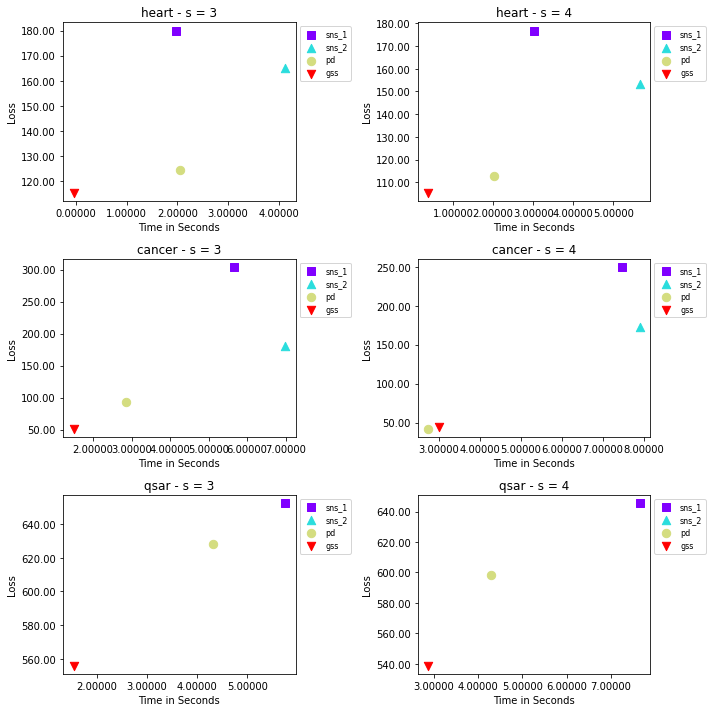

In [ ]:
################################################
# PLOT LOSS AND TIME COMPARISON OF ALL METHODS #
################################################

fig, axs = plt.subplots(3, 2, figsize = (10,10))

r = 0
for ds_name, ds_dict in results.items():
  c = 0  
  for s, s_dict in ds_dict.items():

    colors = iter(cm.rainbow(np.linspace(0, 1, len(s_dict))))
    marker = itertools.cycle((',', "^", 'o', "v", '*', '^')) 
    for k, v in s_dict.items():
      axs[r, c].scatter(np.log(v[2]), v[0],color=next(colors), label = k, marker = next(marker), s = 70)
    title = "{} - s = {}".format(ds_name,s)
    axs[r, c].set_title(title)
    axs[r, c].yaxis.set_major_formatter(FormatStrFormatter('%.2f')) 
    axs[r, c].xaxis.set_major_formatter(FormatStrFormatter('%.5f'))
    axs[r, c].set_xlabel('Time in Seconds')
    axs[r, c].set_ylabel('Loss')
    axs[r, c].legend(loc='upper left', numpoints=1, ncol=1, fontsize=8, bbox_to_anchor=(1, 1))
    c += 1
  r += 1
fig.tight_layout()

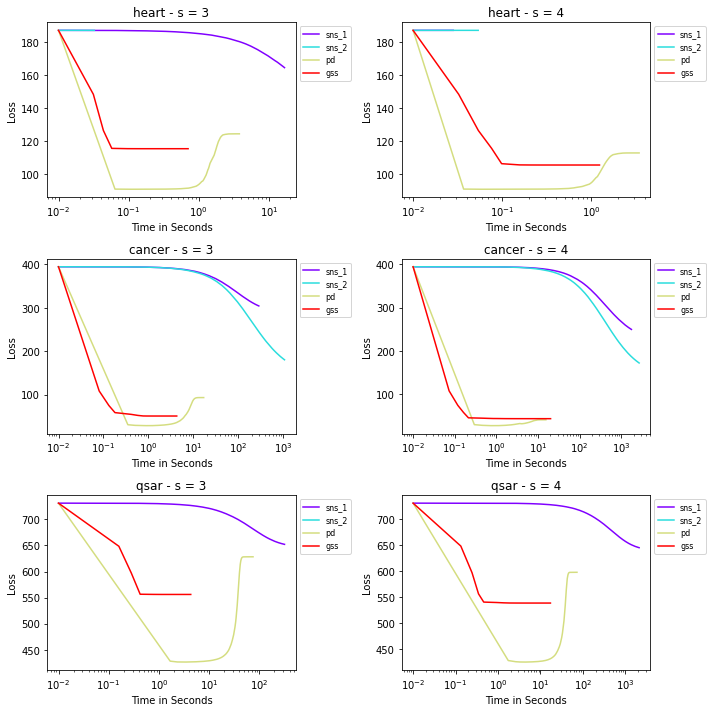

In [ ]:
################################################
# PLOT LOSS AND TIME COMPARISON OF ALL METHODS #
################################################

fig, axs = plt.subplots(3, 2, figsize = (10,10))

r = 0
for ds_name, ds_dict in results.items():
  c = 0  
  for s, s_dict in ds_dict.items():

    colors = iter(cm.rainbow(np.linspace(0, 1, len(s_dict))))
    marker = itertools.cycle((',', "^", 'o', "v", '*', '^')) 
    for k, v in s_dict.items():
      if (ds_name == 'qsar') & (k == 'sns_2'):
        v = (731.2702754907423,v[1],[0],[731.2702754907423],[0])
      axs[r, c].semilogx(list(np.array(v[4])+0.01), v[3],color=next(colors), label = k)
      # axs[r, c].plot(list(v[4]), v[3],color=next(colors), label = k, marker = next(marker))
    title = "{} - s = {}".format(ds_name,s)
    axs[r, c].set_title(title)
    axs[r, c].set_xlabel('Time in Seconds')
    axs[r, c].set_ylabel('Loss')
    axs[r, c].legend(loc='upper left', numpoints=1, ncol=1, fontsize=8, bbox_to_anchor=(1, 1))
    c += 1
  r += 1
fig.tight_layout()

### Experiment 2:
Compares the loss and runtime of each algorithm with different starting points in the Heart data.

*   Performance across all starting points align with the results from Experiement 1
*   PD and GSS have very consistent results and nearly identical loss for every starting point.
* SNS ($\rho=1$ and $s=3$) had the highest variance in runtime and loss. As Run time increases, loss improved, but was never between then GSS and PD. 



In [ ]:
#############################################################
# DISPLAY TABLE FOR RUN TIME WITH DIFFERENT STARTING POINTS #
#############################################################

dist_df

,sns_1_loss,sns_1_time,pd_loss,pd_time,gss_loss,gss_time
0,162.081135,16.974290,115.29519,3.600581,115.266473,0.757496
1,162.081552,16.939816,115.29519,3.366992,115.266473,0.678499
2,155.487898,15.920019,115.29519,3.122873,115.266473,0.624822
3,162.122039,14.630033,115.29519,3.202643,115.266473,0.709197
4,157.606498,15.487953,115.29519,3.747683,115.266473,0.623623
5,162.067517,16.149201,115.29519,3.338882,115.266473,0.731400
6,162.081141,16.354053,115.29519,3.577261,115.266473,0.617397
7,146.928067,21.704003,115.29519,3.432036,115.257229,0.685007
8,165.202123,18.360313,115.29519,3.321583,115.266473,0.733114


<class 'range'>


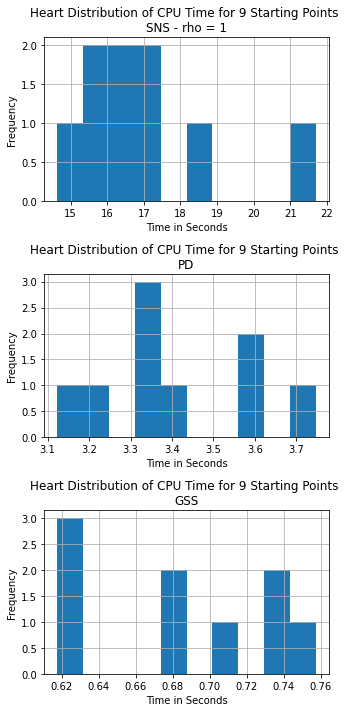

In [ ]:
###############################################################
# PLOT THE DISTRIBUTION OF CPU TIMES BASED ON STARTING POINTS #
###############################################################

fig, ax = plt.subplots(3, figsize = (5,10))

max_range = dist_df[['sns_1_time','pd_time','gss_time']].to_numpy().max()
print(range)

# Plot sns_1
dist_df.sns_1_time.hist(ax=ax[0])
ax[0].set_title('Heart Distribution of CPU Time for 9 Starting Points \nSNS - rho = 1')
ax[0].set_xlabel('Time in Seconds')
ax[0].set_ylabel('Frequency')

# Plot PD
dist_df.pd_time.hist(ax=ax[1])
ax[1].set_title('Heart Distribution of CPU Time for 9 Starting Points \nPD')
ax[1].set_xlabel('Time in Seconds')
ax[1].set_ylabel('Frequency')

# Plot GSS
dist_df.gss_time.hist(ax=ax[2])
ax[2].set_title('Heart Distribution of CPU Time for 9 Starting Points \nGSS')
ax[2].set_xlabel('Time in Seconds')
ax[2].set_ylabel('Frequency')

fig.tight_layout()

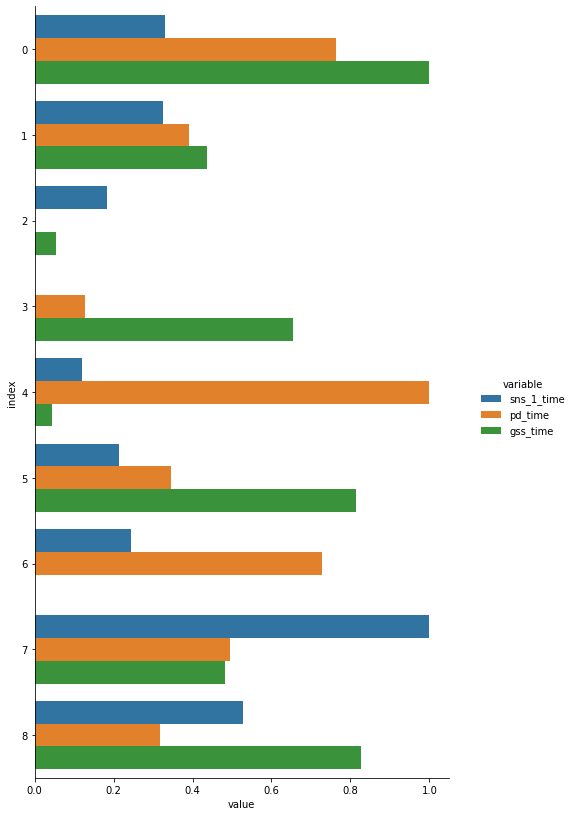

In [ ]:
dist_columns =['sns_1_time','pd_time','gss_time']
dfs1 = pd.DataFrame(MinMaxScaler().fit_transform(dist_df[dist_columns].to_numpy()),columns = dist_columns).reset_index()
dfs1 = pd.melt(dfs1, id_vars='index')
# print(dfs1)
_ = sns.catplot(x = 'value', y='index', 
               hue = 'variable',data=dfs1, orient="h", kind = 'bar')
plt.gcf().set_size_inches(8, 12)

##Results and Conclusion

Overall, all three algorithms discussed in this paper address and can produce sparse solutions for tasks such as feature selection by enforcing sparsity with $L^{0}$ norm constraint.


*   All of these algorithms work, but they all do that in a really different way. 
*   They all create sparse results
*   Even though in our experiments SNS was less efficient then PD and GSS, we acknowledged that the running time and the efficiency of SNS increased as the neighbouring parameter $\rho$ and constraint parameter $s$ increased, that is because the complexity increased.  
*   Through the all experiments it has been acknowledged that what is normal running time and what are the criterias that effects it.

